### Data Science Workflow
by definition a workflow, I can definte a framework for me and explore ideas quicker and easier to work more efficiently.
what can go wrong software development vs ML
[why ML is hard](http://ai.stanford.edu/~zayd/why-is-machine-learning-hard.html)
![](https://s3.amazonaws.com/dq-content/188/why-is-ml-hard.png)


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
train=pd.read_csv('train.csv')
holdout=pd.read_csv('test.csv')

In [3]:
holdout.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


### preprocessing data 
with functions

###### with the help of magic command it is possible to load some file direclty into a cell, for down below we load a file containing a lot of useful function we gonna need later. 

In [4]:
# %load functions.py
def process_missing(df):
    """Handle various missing values from the data set

    Usage
    ------

    holdout = process_missing(holdout)
    """
    df["Fare"] = df["Fare"].fillna(train["Fare"].mean())
    df["Embarked"] = df["Embarked"].fillna("S")
    return df

def process_age(df):
    """Process the Age column into pre-defined 'bins' 

    Usage
    ------

    train = process_age(train)
    """
    df["Age"] = df["Age"].fillna(-0.5)
    cut_points = [-1,0,5,12,18,35,60,100]
    label_names = ["Missing","Infant","Child","Teenager","Young Adult","Adult","Senior"]
    df["Age_categories"] = pd.cut(df["Age"],cut_points,labels=label_names)
    return df

def process_fare(df):
    """Process the Fare column into pre-defined 'bins' 

    Usage
    ------

    train = process_fare(train)
    """
    cut_points = [-1,12,50,100,1000]
    label_names = ["0-12","12-50","50-100","100+"]
    df["Fare_categories"] = pd.cut(df["Fare"],cut_points,labels=label_names)
    return df

def process_cabin(df):
    """Process the Cabin column into pre-defined 'bins' 

    Usage
    ------

    train process_cabin(train)
    """
    df["Cabin_type"] = df["Cabin"].str[0]
    df["Cabin_type"] = df["Cabin_type"].fillna("Unknown")
    df = df.drop('Cabin',axis=1)
    return df

def process_titles(df):
    """Extract and categorize the title from the name column 

    Usage
    ------

    train = process_titles(train)
    """
    titles = {
        "Mr" :         "Mr",
        "Mme":         "Mrs",
        "Ms":          "Mrs",
        "Mrs" :        "Mrs",
        "Master" :     "Master",
        "Mlle":        "Miss",
        "Miss" :       "Miss",
        "Capt":        "Officer",
        "Col":         "Officer",
        "Major":       "Officer",
        "Dr":          "Officer",
        "Rev":         "Officer",
        "Jonkheer":    "Royalty",
        "Don":         "Royalty",
        "Sir" :        "Royalty",
        "Countess":    "Royalty",
        "Dona":        "Royalty",
        "Lady" :       "Royalty"
    }
    extracted_titles = df["Name"].str.extract(' ([A-Za-z]+)\.',expand=False)
    df["Title"] = extracted_titles.map(titles)
    return df

def create_dummies(df,column_name):
    """Create Dummy Columns (One Hot Encoding) from a single Column

    Usage
    ------

    train = create_dummies(train,"Age")
    """
    dummies = pd.get_dummies(df[column_name],prefix=column_name)
    df = pd.concat([df,dummies],axis=1)
    return df

In [5]:
#apply all the functions below
def preprocessingTitanicData(df):
    df=process_missing(df)
    df=process_age(df)
    df=process_fare(df)
    df=process_titles(df)
    df=process_cabin(df)
    for col in ["Age_categories", "Fare_categories","Title", "Cabin_type","Sex"]:
        df=create_dummies(df,col)
    return df 

In [6]:
train=preprocessingTitanicData(train)
holdout=preprocessingTitanicData(holdout)

The workflow for Kaggle competition
![Worflow](https://s3.amazonaws.com/dq-content/188/kaggle_workflow.svg)

### Exploring the Data
we gonna focus on the 2 columns about familiy members abord for each passengers:*Sibsp* and *Parch*

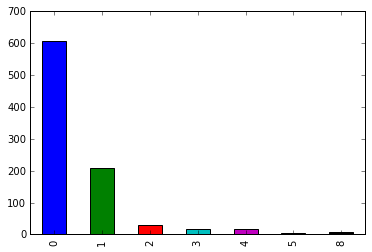

In [7]:
train['SibSp'].value_counts().sort_index().plot.bar()

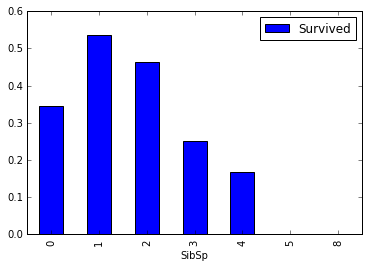

In [8]:
train.pivot_table(index='SibSp',values='Survived').plot.bar()

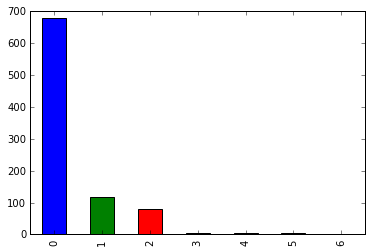

In [9]:
train['Parch'].value_counts().sort_index().plot.bar()

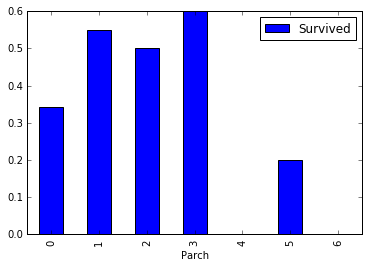

In [10]:
train.pivot_table(index='Parch',values='Survived').plot.bar()

In [11]:
train['family_size']=train[['Parch','SibSp']].sum(axis=1)
train['family_size'].value_counts()

0     537
1     161
2     102
3      29
5      22
4      15
6      12
10      7
7       6
Name: family_size, dtype: int64

In [12]:
#exploring the survival of all families
train.pivot_table(index='family_size',values="Survived")

,Survived
family_size,
0,0.303538
1,0.552795
2,0.578431
3,0.724138
4,0.200000
5,0.136364
6,0.333333
7,0.000000
10,0.000000


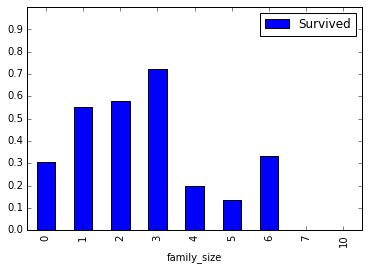

In [13]:
import numpy as np
train.pivot_table(index='family_size',values="Survived").plot.bar(ylim=(0,1),yticks=np.arange(0,1,.1))

###### observations
Having family members increase chance of survival until 3.
so being alone is not good for your survival and we could use this info as a features. 

### Exploring new feature

In [14]:
#works but better to write a function to create this new featur 
#for reusability
train['isalone']=train['family_size'].apply(lambda x: 1 if x ==0 else 0)

holdout['family_size']=holdout[['Parch','SibSp']].sum(axis=1)
holdout['isalone']=holdout['family_size'].apply(lambda x: 1 if x ==0 else 0)

### Selecting best-performing Features aka grid search
function that
- Accepts a dataframe as input
- Performs data preparation for machine learning
- Uses recursive feature elimination and the random forests algorithm to find the best-performing set of features

In [15]:
from sklearn.feature_selection import RFECV
from sklearn.ensemble import RandomForestClassifier

#select the numeric columns and make sure no null values
df=train.select_dtypes(include='number')
df.isnull().sum().sum()
all_X=df.drop(['PassengerId','Survived'],axis=1)
all_y=df['Survived']

estimator_rf=RandomForestClassifier(random_state=1)
selector=RFECV(estimator_rf,cv=10)
selector.fit(all_X,all_y)

/dataquest/system/env/python3/lib/python3.4/site-packages/sklearn/utils/__init__.py:54: FutureWarning:

Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.



RFECV(cv=10,
   estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=1,
            verbose=0, warm_start=False),
   n_jobs=1, scoring=None, step=1, verbose=0)

Optimal number of features : 34


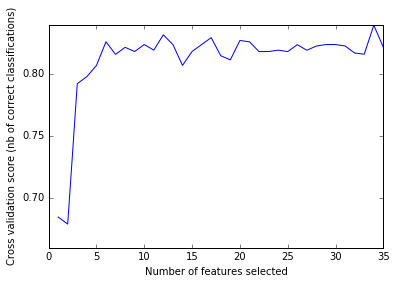

In [16]:
print("Optimal number of features : %d" % selector.n_features_)

# Plot number of features VS. cross-validation scores
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.plot(range(1, len(selector.grid_scores_) + 1), selector.grid_scores_)
plt.show()

In [17]:
optimizided_cols=all_X.columns[selector.support_]
print(optimizided_cols)

Index(['Pclass', 'Age', 'SibSp', 'Parch', 'Fare', 'Age_categories_Missing',
       'Age_categories_Infant', 'Age_categories_Child',
       'Age_categories_Teenager', 'Age_categories_Young Adult',
       'Age_categories_Adult', 'Age_categories_Senior', 'Fare_categories_0-12',
       'Fare_categories_12-50', 'Fare_categories_50-100',
       'Fare_categories_100+', 'Title_Master', 'Title_Miss', 'Title_Mr',
       'Title_Mrs', 'Title_Officer', 'Title_Royalty', 'Cabin_type_A',
       'Cabin_type_B', 'Cabin_type_C', 'Cabin_type_D', 'Cabin_type_E',
       'Cabin_type_F', 'Cabin_type_G', 'Cabin_type_Unknown', 'Sex_female',
       'Sex_male', 'family_size', 'isalone'],
      dtype='object')


##### the function

In [18]:
def select_features(df):
    df=df.select_dtypes(include='number')
    df.isnull().sum().sum()
    all_X=df.drop(['PassengerId','Survived'],axis=1)
    all_y=df['Survived']

    estimator_rf=RandomForestClassifier(random_state=1)
    selector=RFECV(estimator_rf,cv=10)
    selector.fit(all_X,all_y)
    
    optimizided_cols=all_X.columns[selector.support_]
    print(optimizided_cols)
    return optimizided_cols

    

In [19]:
best_features=select_features( train)

Index(['Pclass', 'Age', 'SibSp', 'Parch', 'Fare', 'Age_categories_Missing',
       'Age_categories_Infant', 'Age_categories_Child',
       'Age_categories_Teenager', 'Age_categories_Young Adult',
       'Age_categories_Adult', 'Age_categories_Senior', 'Fare_categories_0-12',
       'Fare_categories_12-50', 'Fare_categories_50-100',
       'Fare_categories_100+', 'Title_Master', 'Title_Miss', 'Title_Mr',
       'Title_Mrs', 'Title_Officer', 'Title_Royalty', 'Cabin_type_A',
       'Cabin_type_B', 'Cabin_type_C', 'Cabin_type_D', 'Cabin_type_E',
       'Cabin_type_F', 'Cabin_type_G', 'Cabin_type_Unknown', 'Sex_female',
       'Sex_male', 'family_size', 'isalone'],
      dtype='object')


/dataquest/system/env/python3/lib/python3.4/site-packages/sklearn/utils/__init__.py:54: FutureWarning:

Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.



### Selecting and Tuning different Algorithms with Grid Search


In [20]:
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression

In [21]:
list_models=[{
    "name": "KNeighborsClassifier",
    "estimator": KNeighborsClassifier(),
    "hyperparameters":
        {
            "n_neighbors": range(1,20,2),
            "weights": ["distance", "uniform"],
            "algorithm": ["ball_tree", "kd_tree", "brute"],
            "p": [1,2]
        }
},
    {"name": "LogisticRegression",
    "estimator": LogisticRegression(),
    "hyperparameters":
         {
             'solver':["newton-cg", "lbfgs", "liblinear"]
         }
    
},
    {'name':'RandomForestClassifier',
     'estimator':RandomForestClassifier(),
     'hyperparameters':
     {
             "n_estimators": [4, 6, 9],
             "criterion": ["entropy", "gini"],
             "max_depth": [2, 5, 10],
             "max_features": ["log2", "sqrt"],
             "min_samples_leaf": [1, 5, 8],
             "min_samples_split": [2, 3, 5]
     }
}]

In [22]:
def select_models(df,features):
    all_X=df[features]
    all_y=df['Survived']
    

    for k in list_models:
        print(k['name'])
        selector=GridSearchCV(k['estimator'],
                              param_grid=k['hyperparameters'],
                             cv=10)
        selector.fit(all_X,all_y)
        k['best_params']=selector.best_params_
        k['best_score']=selector.best_score_
        k['best_estimator']=selector.best_estimator_
        
        print(k['best_params'],k['best_score'])
    return list_models

In [23]:
perf_models=select_models(train,optimizided_cols)

KNeighborsClassifier
{'algorithm': 'kd_tree', 'p': 1, 'weights': 'uniform', 'n_neighbors': 3} 0.7800224466891134
LogisticRegression
{'solver': 'newton-cg'} 0.8181818181818182
RandomForestClassifier
{'n_estimators': 9, 'max_features': 'sqrt', 'max_depth': 10, 'criterion': 'gini', 'min_samples_leaf': 1, 'min_samples_split': 5} 0.8439955106621774


### sumission to kaggle

In [29]:
def save_submission_file(model,features,file_name):
    holdout_predictions=model.predict(holdout[features])
    submission_df={'PassengerID':holdout['PassengerId'],
                   'Survived':holdout_predictions}
    submission=pd.DataFrame(submission_df)
    submission.to_csv('{}.csv'.format(file_name),index=False)

In [30]:
best_model=perf_models[2]['best_estimator']

In [31]:
save_submission_file(best_model,optimizided_cols,'ThibaudTitanicPredictions')

#### to go further:
We encourage you to continue working on this Kaggle competition. Here are some suggestions of next steps:

- Continue to explore the data and create new features, following the workflow and using the functions we created.
- Read more about the titanic and this Kaggle competition to get ideas for new features.
- Use some different algorithms in the select_model() function, like support vector machines, stochastic gradient descent or perceptron linear models.
- Experiment with RandomizedSearchCV instead of GridSearchCV to speed up your select_features() function.

(solution)[https://github.com/dataquestio/solutions/blob/master/Mission188Solution.ipynb]
[kaggle house price competition](https://www.dataquest.io/blog/kaggle-getting-started/)